<a href="https://colab.research.google.com/github/HR0262/AI-in-transportation-assignments/blob/main/project/projectcodexgblstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv("training_dataset.csv",sep=";")
train_df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0
...,...,...,...,...,...,...,...,...,...,...,...
1921962,353,"E4S 57,055",20211231,10:00:00,600,120,40,20,10,17.45,11.0
1921963,543,"E4S 56,780",20211231,10:00:00,600,120,40,20,10,18.09,11.0
1921964,153,"E4S 56,490",20211231,10:00:00,600,120,40,20,10,23.53,7.0
1921965,351,"E4S 56,490",20211231,10:00:00,600,120,40,20,10,18.49,9.0


In [2]:
# new dataframe for sum speed and flow
portal_avg_df = train_df.groupby(['PORTAL', 'Date', 'Time'], as_index=False).agg({
    'Interval_1': 'first',  # Keep the first value of the interval column
    'Interval_5': 'first',
    'Interval_15': 'first',
    'Interval_30': 'first',
    'Interval_60': 'first',
    'SPEED_MS_AVG': 'mean',  # Calculate average speed
    'FLOW': 'sum'  # Calculate sum flow
})

# sorting the value to original
portal_avg_df = portal_avg_df.sort_values(by=['Date', 'Time'])

# Save to CSV
# portal_avg_df.to_csv('portal_avg_speed_flow_with_intervals.csv', index=False)

# show data
portal_avg_df

,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,"E4S 55,620",20210601,04:00:00,240,48,16,8,4,22.110000,29.0
74333,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,23.326667,28.0
148548,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,21.460000,24.0
224995,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,20.047500,27.0
301341,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,20.520000,27.0
...,...,...,...,...,...,...,...,...,...,...
301340,"E4S 56,780",20211231,10:00:00,600,120,40,20,10,17.907500,40.0
375372,"E4S 57,055",20211231,10:00:00,600,120,40,20,10,18.993333,42.0
451461,"E4S 57,435",20211231,10:00:00,600,120,40,20,10,21.206667,25.0
527686,"E4S 57,820",20211231,10:00:00,600,120,40,20,10,21.106667,20.0


In [3]:
# Get the unique portal values
portal_ids = portal_avg_df['PORTAL'].unique()

# Create a dictionary to hold the split dataframes
portal_avg_dfs = {}

# Loop through each PORTAL and create a separate dataframe
for portal_id in portal_ids:
    portal_avg_dfs[f'portal_avg_df_{portal_id}'] = portal_avg_df[portal_avg_df['PORTAL'] == portal_id]
print(portal_ids)

['E4S 55,620' 'E4S 56,160' 'E4S 56,490' 'E4S 56,780' 'E4S 57,055'
 'E4S 57,435' 'E4S 57,820' 'E4S 58,140']


In [4]:
from datetime import datetime
# 创建一个空的列表来存储每个portal的向量化数据集  Create an empty list to store the vectorised dataset for each portal
vectorized_portal_datasets = []
nintvals=361
# 首先，找到所有portal中出现的唯一的日期  First, find the unique date that appears in all portals
all_days = set()
for portal in portal_ids:
    df = portal_avg_dfs[f'portal_avg_df_{portal}']
    df_sorted = df.sort_values(["Date", "Interval_1"])
    all_days.update(df_sorted['Date'].unique())
all_days = sorted(all_days)
all_days_formatted = [datetime.strptime(str(day), '%Y%m%d').date() for day in all_days]
print(all_days)

# 循环遍历每个portal  Loop through each portal
for portal in portal_ids:
    df = portal_avg_dfs[f'portal_avg_df_{portal}']
    df_sorted = df.sort_values(["Date", "Interval_1"])

    # 提取唯一的日期  Extract unique date
    days = np.unique(df_sorted['Date'].values)

    # 计算总天数  Calculate the total number of days
    ndays = len(days)

    # 按日期分组  Grouping by date
    day_subsets_df = df_sorted.groupby(["Date"])

    # 创建一个填满NaN值的矩阵  Create a matrix filled with NaN values
    vectorized_day_dataset = np.full((len(all_days), nintvals), np.nan)

    # 循环遍历每个唯一的天  Loop through each unique day
    for i, day in enumerate(all_days):
        if day in days:
            df_t = day_subsets_df.get_group(day)

            # 循环遍历当前天的DataFrame的每一行  Loop through each row of the DataFrame for the current day
            for j in range(len(df_t)):
                # 提取"Interval_1"和"FLOW"值，并填充'vectorized_day_dataset'  Extract the 'Interval_1' and 'FLOW' values and populate the 'vectorized_day_dataset'
                interval_index = df_t.iloc[j]["Interval_1"] - 240
                if 0 <= interval_index < nintvals:  # 确保索引有效  Make sure the index is valid
                    vectorized_day_dataset[i, interval_index] = df_t.iloc[j]["FLOW"]

    # 将当前portal的向量化数据集添加到列表中  Add the vectorised dataset of the current portal to the list
    vectorized_portal_datasets.append(vectorized_day_dataset)

# 将所有向量化数据集合并为一个大的三维数组  Merge all vectorised datasets into one large 3D array
final_vectorized_dataset = np.array(vectorized_portal_datasets)

# 打印结果  Print the results
print(final_vectorized_dataset)
print(final_vectorized_dataset.shape)

[20210601, 20210602, 20210603, 20210604, 20210605, 20210606, 20210607, 20210608, 20210609, 20210610, 20210611, 20210612, 20210613, 20210614, 20210615, 20210616, 20210617, 20210618, 20210619, 20210620, 20210621, 20210622, 20210623, 20210624, 20210625, 20210626, 20210627, 20210628, 20210629, 20210630, 20210701, 20210702, 20210703, 20210704, 20210705, 20210706, 20210707, 20210708, 20210709, 20210710, 20210711, 20210712, 20210713, 20210714, 20210715, 20210716, 20210717, 20210718, 20210719, 20210720, 20210721, 20210722, 20210723, 20210724, 20210725, 20210726, 20210727, 20210728, 20210729, 20210730, 20210731, 20210801, 20210802, 20210803, 20210804, 20210805, 20210806, 20210807, 20210808, 20210809, 20210810, 20210811, 20210812, 20210813, 20210814, 20210815, 20210816, 20210817, 20210818, 20210819, 20210820, 20210821, 20210822, 20210823, 20210824, 20210825, 20210826, 20210827, 20210828, 20210829, 20210830, 20210831, 20210901, 20210902, 20210903, 20210904, 20210905, 20210906, 20210907, 20210908,

<ipython-input-4-ff6e5d0f9f36>:35: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(day)


[[[29. 26. 38. ... 60. 46. 68.]
  [29. 23. 29. ... 54. 59. 59.]
  [37. 35. 36. ... 57. 40. 53.]
  ...
  [ 1.  6.  3. ... 50. 47. 45.]
  [ 6.  3.  6. ... 42. 46. 62.]
  [ 2.  3.  1. ... 24. 14. 16.]]

 [[28. 33. 42. ... 47. 59. 61.]
  [26. 29. 35. ... 54. 59. 52.]
  [34. 38. 27. ... 45. 49. 51.]
  ...
  [ 3.  4.  4. ... 50. 43. 56.]
  [ 4.  5.  6. ... 38. 54. 57.]
  [ 2.  1.  1. ... 14. 16. 27.]]

 [[24. 38. 43. ... 55. 64. 69.]
  [25. 35. 37. ... 60. 64. 57.]
  [35. 36. 34. ... 50. 55. 58.]
  ...
  [ 4.  6.  2. ... 49. 53. 62.]
  [ 3.  7.  7. ... 48. 58. 56.]
  [ 2.  3.  2. ... 18. 13. 42.]]

 ...

 [[ 4.  3.  5. ... 58. 54. 69.]
  [ 3.  2.  1. ... 58. 57. 66.]
  [ 8.  4.  6. ... 59. 61. 66.]
  ...
  [ 4.  1.  6. ... 49. 39. 44.]
  [ 2.  4.  8. ... 36. 40. 28.]
  [ 1.  3.  4. ... 22. 23. 25.]]

 [[ 4.  3.  7. ... 50. 60. 72.]
  [ 3.  1.  4. ... 60. 57. 60.]
  [ 8.  3.  7. ... 59. 52. 68.]
  ...
  [ 2.  3.  5. ... 48. 49. 30.]
  [ 1.  7.  7. ... 31. 43. 33.]
  [nan  4.  4. ... 18. 24. 2

In [5]:
#提取speed  Extraction speed
vectorized_portal_datasets=[]
for portal in portal_ids:
    portal = 'E4S 55,620'
    df = portal_avg_dfs[f'portal_avg_df_{portal}']
    df_sorted = df.sort_values(["Date", "Interval_1"])

    # 提取唯一的日期  Extract unique date
    days = np.unique(df_sorted['Date'].values)

    # 计算总天数  Calculate the total number of days
    ndays = len(days)

    # 按日期分组  Grouping by date
    day_subsets_df = df_sorted.groupby(["Date"])

    # 创建一个填满NaN值的矩阵  Create a matrix filled with NaN values
    vectorized_day_dataset = np.full((len(all_days), nintvals), np.nan)

    # 循环遍历每个唯一的天  Loop through each unique day
    for i, day in enumerate(all_days):
        if day in days:
            df_t = day_subsets_df.get_group(day)

            # 循环遍历当前天的DataFrame的每一行  Loop through each row of the DataFrame for the current day
            for j in range(len(df_t)):
                # 提取"Interval_1"和"FLOW"值，并填充'vectorized_day_dataset'  Extract the 'Interval_1' and 'FLOW' values and populate the 'vectorized_day_dataset'
                interval_index = df_t.iloc[j]["Interval_1"] - 240
                if 0 <= interval_index < nintvals:  # 确保索引有效  Make sure the index is valid
                    vectorized_day_dataset[i, interval_index] = df_t.iloc[j]["SPEED_MS_AVG"]
    # 将当前portal的向量化数据集添加到列表中  Add the vectorised dataset of the current portal to the list
    vectorized_portal_datasets.append(vectorized_day_dataset)

# 将所有向量化数据集合并为一个大的三维数组  Merge all vectorised datasets into one large 3D array
final_vectorized_dataset_speed = np.array(vectorized_portal_datasets)

# 打印结果  Print the results
print(final_vectorized_dataset_speed)
print(final_vectorized_dataset_speed.shape)

<ipython-input-5-4ac3e2204235>:23: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(day)


[[[22.11       23.53333333 21.83       ... 19.09       17.96
   19.48333333]
  [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
   19.52666667]
  [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
   20.33666667]
  ...
  [18.6        19.77       19.9        ... 18.89       19.54333333
   19.15333333]
  [23.05       22.23       21.415      ... 20.14333333 19.26666667
   18.53333333]
  [21.4        25.35       20.3        ... 20.84       21.23666667
   22.44      ]]

 [[22.11       23.53333333 21.83       ... 19.09       17.96
   19.48333333]
  [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
   19.52666667]
  [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
   20.33666667]
  ...
  [18.6        19.77       19.9        ... 18.89       19.54333333
   19.15333333]
  [23.05       22.23       21.415      ... 20.14333333 19.26666667
   18.53333333]
  [21.4        25.35       20.3        ... 20.84       21.23666667
   22.44      ]]

 [[22.11    

In [6]:
#choose different portal for training, E4S 55,620, the first one in this place
vectorized_day_dataset_speed0 = final_vectorized_dataset_speed[0]
vectorized_day_dataset_flow0 = final_vectorized_dataset[0]
print(vectorized_day_dataset_speed0)
print(vectorized_day_dataset_flow0)

[[22.11       23.53333333 21.83       ... 19.09       17.96
  19.48333333]
 [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
  19.52666667]
 [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
  20.33666667]
 ...
 [18.6        19.77       19.9        ... 18.89       19.54333333
  19.15333333]
 [23.05       22.23       21.415      ... 20.14333333 19.26666667
  18.53333333]
 [21.4        25.35       20.3        ... 20.84       21.23666667
  22.44      ]]
[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 1.  6.  3. ... 50. 47. 45.]
 [ 6.  3.  6. ... 42. 46. 62.]
 [ 2.  3.  1. ... 24. 14. 16.]]


[18 18 18 18 22 20 20 20 18 20 24 18 24 18 18 18 20 18 18 18 18 18 20 18
 18 18 20 18 20 18 18 18 18 18 18 18 18 18 18 22 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 20 18 20 18 18 20 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 20 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 20 18 18 18 18 18 18 18 18 18 18 18 18 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 18 18 18 18 18 16 16 16 16 16 16 16 18 18 18 18 18 18 18
 18 18 16 16 16 16 16 16 16 16 16 16 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 14 12 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 14 14 14 14 14 14 14 14 14 14 14 16 14

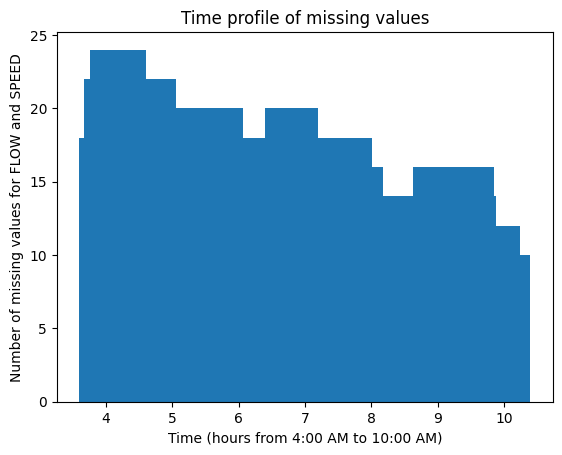

In [8]:
# Calculate the number of missing values per 1-minute interval
nans_per_time_all_portals = np.zeros(361,)

# # 循环遍历每个portal  Loop through each portal
# for i in range(8):
#     # 计算当前portal的每个时间间隔的缺失值数量  Count the number of missing values for each time interval of the current portal
#     nans_per_time = np.sum(np.isnan(final_vectorized_dataset[i]), axis=0)
#     # 累加到总缺失值数组  Accumulate to an array of total missing values
#     nans_per_time_all_portals += nans_per_time

nans_per_time_all_portals = np.sum(np.isnan(vectorized_day_dataset_speed0), axis=0) + np.sum(np.isnan(vectorized_day_dataset_flow0), axis=0)
print(nans_per_time_all_portals)
print(nans_per_time_all_portals.shape)

# Define the number of 1-minute intervals between 4:00 AM and 10:00 AM
nintvals = 361  # 6 hours * 60 minutes = 360 intervals

# Create an array 'x_axis' representing the 1-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)

# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []

# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
    x_axis_hours.append(4 + float(x_axis[i]) / 60)  # Start at 4 AM, and each interval is 1 minute

# Plot the number of missing values over time
fig, ax = plt.subplots()
ax.bar(x_axis_hours, height=nans_per_time_all_portals)
print(sum(nans_per_time_all_portals)/(8*214*361))
# Set labels and title
ax.set_ylabel('Number of missing values for FLOW and SPEED')
ax.set_xlabel('Time (hours from 4:00 AM to 10:00 AM)')
ax.set_title('Time profile of missing values')

# Display the plot
plt.show()

In [10]:
# final_vectorized_dataset_2d = final_vectorized_dataset.transpose(1, 0, 2).reshape(-1, final_vectorized_dataset.shape[2])
# print(final_vectorized_dataset_2d)
# print(final_vectorized_dataset_2d.shape)

In [12]:
# #插值  interpolation

# 自定义函数进行周期性插值  Custom functions for periodic interpolation
def periodic_interpolation(df, period):
    df = pd.DataFrame(df)
    # 对于每一列（代表一个时间间隔）  For each column (representing a time interval)
    for col in df.columns:
        # 遍历每一行  Go through each row
        for i in range(len(df)):
            # 如果当前行有缺失值  If the current row has a missing value
            if np.isnan(df[col][i]):
                # 向前找到当前周期中对应的行（例如，如果今天是星期三，我们查看上一个星期三）  Move forward to find the corresponding row in the current period (e.g. if today is Wednesday, we look at the previous Wednesday)
                idx_left = (i + period) % len(df)
                # 如果对应的行也有缺失值，继续向后查找直到找到非缺失值  If the corresponding row also has a missing value, continue looking backwards until you find a non-missing value
                while np.isnan(df[col][idx_left]) and idx_left>=0:
                    idx_left = (idx_left + period) % len(df)
                # 向后找  Look backwards
                idx_right = (i + period) % len(df)
                while np.isnan(df[col][idx_right]) and idx_right<len(df):
                    idx_right = (idx_right + period) % len(df)
                # 用找到的非缺失值线性填充当前缺失值  The currently missing value is linearly populated with the found non-missing value
                if idx_right>=len(df):
                  df[col][i] = df[col][idx_left]
                elif idx_left<=0:
                  df[col][i] = df[col][idx_right]
                else:
                  df[col][i] = np.mean([df[col][idx_left], df[col][idx_right]])
    df = df.to_numpy()
    return df

# # 应用周期性插值  Apply periodic interpolation
# df_interpolated = periodic_interpolation(df, 7*8)


# # 将插值后的 DataFrame 转换回 NumPy 数组  Convert the interpolated DataFrame back to a NumPy array
# final_vectorized_dataset_2d = df_interpolated.to_numpy()

# print(final_vectorized_dataset_2d)
# print(final_vectorized_dataset_2d.shape)

In [14]:
vectorized_day_dataset_speed0_interpolated = periodic_interpolation(vectorized_day_dataset_speed0, 7)
vectorized_day_dataset_flow0_interpolated = periodic_interpolation(vectorized_day_dataset_flow0, 7)
print(vectorized_day_dataset_speed0_interpolated)
print(vectorized_day_dataset_flow0_interpolated)


<ipython-input-12-c8460a98ecfa>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col][i] = np.mean([df[col][idx_left], df[col][idx_right]])
<ipython-input-12-c8460a98ecfa>:25: FutureWarning: ChainedAssignmentError: behaviour will change 

[[22.11       23.53333333 21.83       ... 19.09       17.96
  19.48333333]
 [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
  19.52666667]
 [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
  20.33666667]
 ...
 [18.6        19.77       19.9        ... 18.89       19.54333333
  19.15333333]
 [23.05       22.23       21.415      ... 20.14333333 19.26666667
  18.53333333]
 [21.4        25.35       20.3        ... 20.84       21.23666667
  22.44      ]]
[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 1.  6.  3. ... 50. 47. 45.]
 [ 6.  3.  6. ... 42. 46. 62.]
 [ 2.  3.  1. ... 24. 14. 16.]]


In [16]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset_speed0_interpolated),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))
nans_per_day = np.sum(np.isnan(vectorized_day_dataset_flow0_interpolated),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 0
number of days with missing value 0


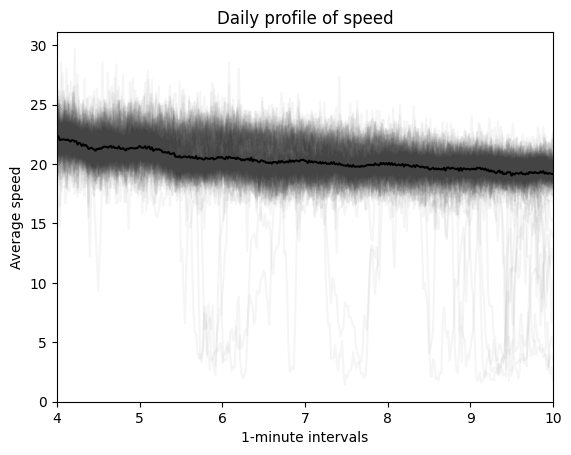

In [23]:
final_vectorized_dataset_2d_daysum_speed = vectorized_day_dataset_speed0_interpolated
# final_vectorized_dataset_2d_daysum = np.zeros(final_vectorized_dataset[0].shape)
# for i in range(1, 8):
#   final_vectorized_dataset_2d_daysum += final_vectorized_dataset[i]

ndays = 214
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),final_vectorized_dataset_2d_daysum_speed.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(final_vectorized_dataset_2d_daysum_speed,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Average speed')
ax.set_xlabel('1-minute intervals')
plt.xlim(4,10)
ax.set_title('Daily profile of speed')

plt.show()

In [21]:
import datetime

# Create an array 'day_of_week' to store the day of the week for each unique date
day_of_week = np.zeros((ndays))

# Loop through each unique date
for i in range(0, ndays):
    # Parse the current date from a string to a datetime object
    day_dt = datetime.datetime.strptime(str(all_days[i]), '%Y%m%d')

    # Get the day of the week (1 for Monday, 2 for Tuesday, ..., 7 for Sunday)
    day_of_week[i] = day_dt.isoweekday()

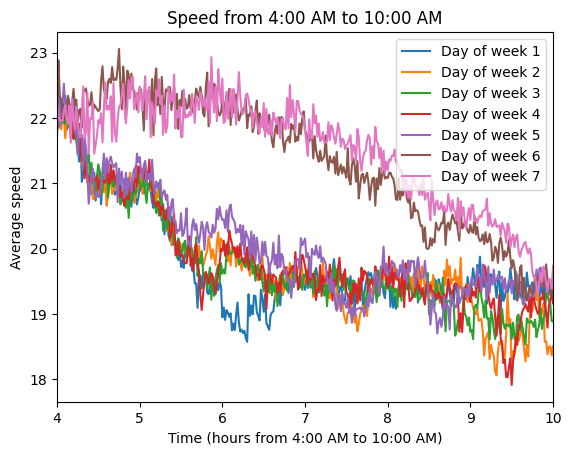

In [27]:
# Define the number of 1-minute intervals between 4:00 AM and 10:00 AM
nintvals = 361  # 6 hours * 60 minutes + 1 extra interval = 361 intervals

# Create an array 'x_axis_hours' representing time in hours from 4:00 AM to 10:00 AM
# Use linspace to generate exactly 361 time points between 4 and 10
x_axis_hours = np.linspace(4, 10, nintvals)

# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    ax.plot(x_axis_hours,  # Plot using the full 361 intervals
            np.nanmean(final_vectorized_dataset_2d_daysum_speed[day_of_week_index_t[0], :nintvals].transpose(), 1),
            label='Day of week ' + str(i))

# Set the y-axis label
ax.set_ylabel('Average speed')

# Set the x-axis label
ax.set_xlabel('Time (hours from 4:00 AM to 10:00 AM)')

# Set the x-axis limits to be between 4 and 10
plt.xlim(4, 10)

# Set the title of the plot
ax.set_title('Speed from 4:00 AM to 10:00 AM')

# Add a legend indicating the day of the week
ax.legend()

# Display the plot
plt.show()

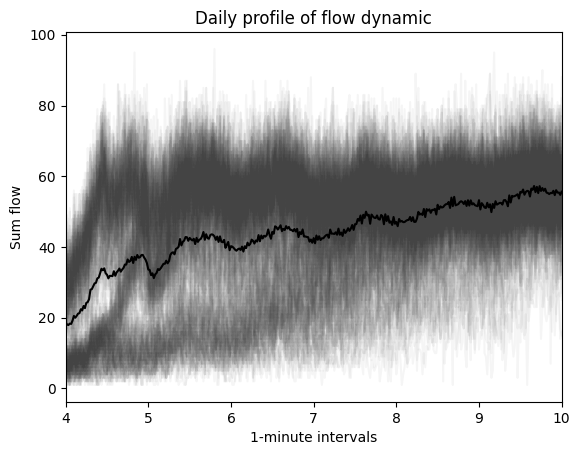

In [28]:
final_vectorized_dataset_2d_daysum_flow = vectorized_day_dataset_flow0_interpolated
# final_vectorized_dataset_2d_daysum = np.zeros(final_vectorized_dataset[0].shape)
# for i in range(1, 8):
#   final_vectorized_dataset_2d_daysum += final_vectorized_dataset[i]

ndays = 214
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),final_vectorized_dataset_2d_daysum_flow.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(final_vectorized_dataset_2d_daysum_flow,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Sum flow')
ax.set_xlabel('1-minute intervals')
plt.xlim(4,10)
ax.set_title('Daily profile of flow dynamic')

plt.show()

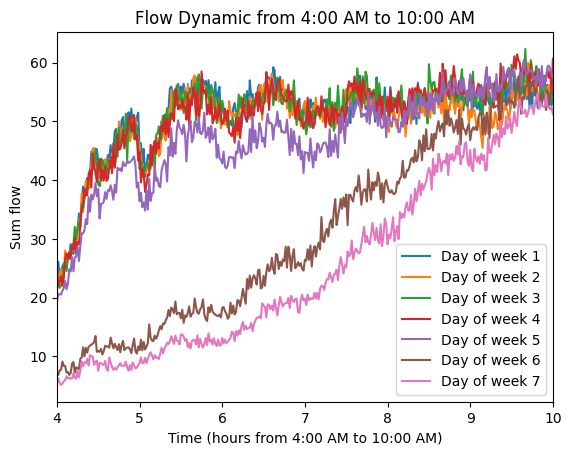

In [29]:
# Define the number of 1-minute intervals between 4:00 AM and 10:00 AM
nintvals = 361  # 6 hours * 60 minutes + 1 extra interval = 361 intervals

# Create an array 'x_axis_hours' representing time in hours from 4:00 AM to 10:00 AM
# Use linspace to generate exactly 361 time points between 4 and 10
x_axis_hours = np.linspace(4, 10, nintvals)

# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    ax.plot(x_axis_hours,  # Plot using the full 361 intervals
            np.nanmean(final_vectorized_dataset_2d_daysum_flow[day_of_week_index_t[0], :nintvals].transpose(), 1),
            label='Day of week ' + str(i))

# Set the y-axis label
ax.set_ylabel('Sum flow')

# Set the x-axis label
ax.set_xlabel('Time (hours from 4:00 AM to 10:00 AM)')

# Set the x-axis limits to be between 4 and 10
plt.xlim(4, 10)

# Set the title of the plot
ax.set_title('Flow Dynamic from 4:00 AM to 10:00 AM')

# Add a legend indicating the day of the week
ax.legend()

# Display the plot
plt.show()

In [30]:
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True, ylabel = 'Flow'):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel(ylabel)
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()

In [31]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

#clusters = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(vectorized_day_dataset)

In [32]:
n_clusters = 4
clusters = None
#print(np.where(nans_per_day > 0)[0])
# vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
# days_not_nans = days[np.where(nans_per_day == 0)[0]]

# print(vectorized_day_dataset_speed0_interpolated)
# print(vectorized_day_dataset_flow0_interpolated)
clusterdata = np.concatenate((vectorized_day_dataset_speed0_interpolated, vectorized_day_dataset_flow0_interpolated), axis=1)
print(clusterdata)

# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(clusterdata) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(clusterdata) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
#clusters = DBSCAN(eps=500, min_samples = 2).fit(clusterdata) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
  cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(clusterdata).predict(clusterdata) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)


[[22.11       23.53333333 21.83       ... 60.         46.
  68.        ]
 [23.61333333 22.45666667 22.78333333 ... 54.         59.
  59.        ]
 [23.56666667 22.20666667 23.28       ... 57.         40.
  53.        ]
 ...
 [18.6        19.77       19.9        ... 50.         47.
  45.        ]
 [23.05       22.23       21.415      ... 42.         46.
  62.        ]
 [21.4        25.35       20.3        ... 24.         14.
  16.        ]]
[1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 3 0 1 1 1 1 1 0 0 2 1 2
 1 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 0 2 2 2 2 2 0 0 1 1 1 1 2
 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 0 3 2 2 2 2 2 0 3 2 2 2 2 2 0 3 2 2 2 2 2 0 3 2 2 2 2 2 0 3 2 2 2 2
 2 3 3 2 2 2 2 2 3 3 2 2 2 2 2 3 3 2 2 2 0 3 3 3 0 0 0 0 3]


cluster_id_weekdays_share [7, 84, 61, 2]
cluster_id_weekend_share [46, 0, 0, 14]
111


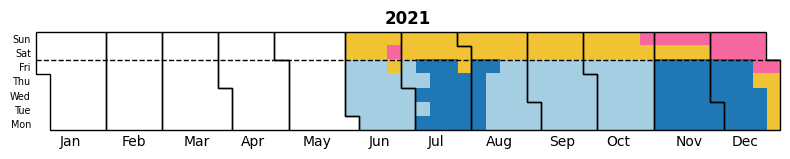

In [33]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, all_days, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(all_days, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).

Visualising different culstering classes

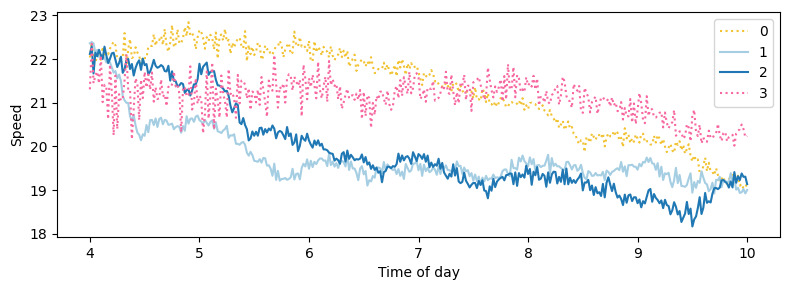

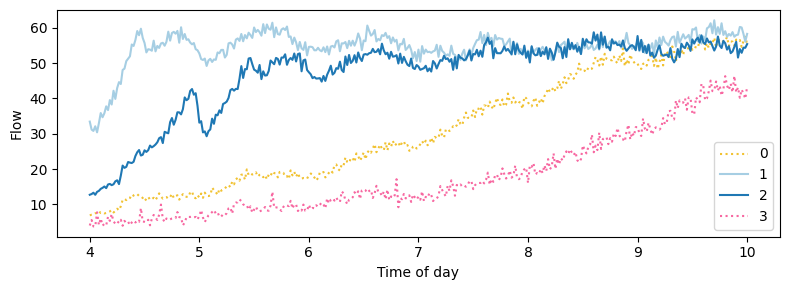

In [34]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes_speed = []  # y-axis values for centroids, grouped by day types
centroids_yy_daytypes_flow = []
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(clusterdata[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_speed = centroid_yy[:361]
    centroids_yy_flow = centroid_yy[361:]
    centroids_yy_daytypes_speed.append(centroids_yy_speed)
    centroids_yy_daytypes_flow.append(centroids_yy_flow)

    # Store the cluster ID
    cluster_ids.append(i)


# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes_speed, color_to_cluster, style_to_cluster, cluster_ids, ylabel = 'Speed')
#
make_figure_centroids(centroids_xx, centroids_yy_daytypes_flow, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

Time series for forecasting----xgboost prediction

mashine learning--30speed, 30flow, 2labels
lstm--30speed, 30flow


In [35]:
# print(final_vectorized_dataset_2d)  #not yet take the clustering into consideration
# print(final_vectorized_dataset_2d.shape)
print(vectorized_day_dataset_speed0_interpolated)
print(vectorized_day_dataset_flow0_interpolated)

[[22.11       23.53333333 21.83       ... 19.09       17.96
  19.48333333]
 [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
  19.52666667]
 [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
  20.33666667]
 ...
 [18.6        19.77       19.9        ... 18.89       19.54333333
  19.15333333]
 [23.05       22.23       21.415      ... 20.14333333 19.26666667
  18.53333333]
 [21.4        25.35       20.3        ... 20.84       21.23666667
  22.44      ]]
[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 1.  6.  3. ... 50. 47. 45.]
 [ 6.  3.  6. ... 42. 46. 62.]
 [ 2.  3.  1. ... 24. 14. 16.]]


Need to split the data into x-62 values, y-next minute values

Remember to divide into training set validation set



In [64]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def datadivide(arr, cluster_labels = [], lag_size = 30, weekend = False, startday = 0, time = 0):
  print(arr.shape)
  rows, columns = arr.shape

  x = []
  y = []

  # Number of input data
  lag_size = 30

  # encoder = OneHotEncoder()
  # one_hot_labels = encoder.fit_transform(cluster_labels.reshape(-1, 1))
  # one_hot_labels = one_hot_labels.toarray()

  # 遍历数组，除了最后 lag_size 个元素  Iterate through the array, except for the last lag_size elements
  for i in range(rows):
    for j in range(columns - lag_size):
      # if cluster_labels[i] == 0:
        # 对于每个时间步长，创建一个包含前 lag_size 个元素的 x 特征数组  For each time step, create an array of x-features containing the first lag_size elements
        x_features = arr[i][j:j+lag_size].flatten()
        # y 是当前时间步长的数据  y is the data for the current time step
        y_value = np.mean(arr[i][j+lag_size:j+lag_size+15])
        # 加入聚类结果  Add clustering results
        if len(cluster_labels)>0:
          x_features = np.append(x_features, cluster_labels[i])
        # 加入当前时间  Add the current time
        if time:
          x_features = np.append(x_features, j//time)
        # x_features = np.append(x_features, i%8)
        # 加入当天的flow_aver  Join the flow_aver of the day
        # flow_aver = np.average(vectorized_day_dataset[i])
        # x_features = np.append(x_features, flow_aver)
        if weekend:
          if i%7+startday ==6 or i%7+startday ==7:
            x_features = np.append(x_features, 1)
          else:
            x_features = np.append(x_features, 0)


        # 将它们添加到相应的列表中  Add them to the appropriate list
        x.append(x_features)
        y.append(y_value)

  # translate it to NumPy array
  x = np.array(x)
  y = np.array(y)

  return x, y

In [65]:
x1, y1 = datadivide(vectorized_day_dataset_speed0_interpolated)
x2, y2 = datadivide(vectorized_day_dataset_flow0_interpolated, cluster_labels= [], time=5, weekend = True, startday = 2)
x = np.concatenate((x1, x2), axis=1)
y = y2
x = np.concatenate((x1, x2), axis=1)
print(x.shape)
print(y.shape)

(214, 361)
(214, 361)
(70834, 62)
(70834,)


pca

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  #standardize it
x_scaled = scaler.fit_transform(x)


# 分离出需要进行PCA降维的特征和不需要降维的特征  Separate the features that require PCA dimensionality reduction and those that do not
features_to_reduce = x[:, :60]  #speed and flow
features_to_keep = x[:, 60:]    #cluster labels and time

pca = PCA(n_components=10)  # Adjust the number of components (dimensions) as needed
features_reduced = pca.fit_transform(features_to_reduce)
print(features_reduced.shape)

explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance Ratio: {explained_variance}')
print(f"Sum of the explained variance: {sum(explained_variance)}")

# 将降维后的特征和原始特征拼接起来  Stitch together the reduced features and the original features
data_transformed = np.hstack((features_reduced, features_to_keep))
print(data_transformed.shape)

# data_transformed = x_scaled

(70834, 10)
Explained Variance Ratio: [0.80448208 0.019775   0.0091033  0.0067205  0.00658147 0.00616613
 0.0061417  0.00613255 0.00609894 0.00609026]
Sum of the explained variance: 0.8772919272505103
(70834, 12)


tran test split ----test size 0.2

Can't be divided randomly because the output will be contained within the inputs

In [51]:
test_size = 0.2

x_train_pca = data_transformed[:int(len(x)*(1-test_size))]
x_test_pca = data_transformed[int(len(x)*(1-test_size)):]
y_train = y[:int(len(y)*(1-test_size))]
y_test = y[int(len(y)*(1-test_size)):]

print(x_train_pca.shape)
print(x_test_pca.shape)
print(y_train.shape)
print(y_test.shape)


(56667, 12)
(14167, 12)
(56667,)
(14167,)


In [52]:
pip install catboost

In [53]:
from mmap import MAP_EXECUTABLE
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# # 定义参数分布  Define the parameter distribution
# param_distribution = {
#     'n_estimators': randint(100, 500),
#     'learning_rate': uniform(0.01, 0.2),
#     'max_depth': randint(3, 10),
#     'min_child_weight': randint(1, 10),
# }

# # 创建XGBRegressor模型  Create an XGBRegressor model
# xgb_reg = XGBRegressor()

# # 创建RandomizedSearchCV对象  Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_distribution,
#     n_iter=100,  # 可以根据需要调整迭代次数  You can adjust the number of iterations as needed
#     scoring='neg_mean_squared_error',
#     cv=3,
#     random_state=42
# )

# # 执行随机搜索  Perform a random search
# random_search.fit(x_train_pca, y_train)

# # 输出最佳参数  Output the best parameters
# print("Best parameters found: ", random_search.best_params_)

# # 输出最佳模型得分  Output the best model score
# print("Best model score: ", random_search.best_score_)

# different models
# model = LinearRegression()
# model = XGBRegressor()
# model = RandomForestRegressor()
# model = SVR()
# model = DecisionTreeRegressor()
model = CatBoostRegressor(verbose=0)
# model = lgb.LGBMRegressor()
# model = GradientBoostingRegressor()
# model = AdaBoostRegressor()



model.fit(x_train_pca, y_train)
y_pred = model.predict(x_test_pca)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 2.8982076384574635
Mean Absolute Percentage Error: 0.11140517653411362
Mean Squared Error: 16.22943368538501
R-squared: 0.9466827523367847


In [82]:
#lstm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# 1. 数据准备 - 滑动窗口生成特征  Data Preparation - Sliding window generates features
def create_lstm_data(data, lag_size, weekend = False, startday = 0, time = 0):
    x = []
    y = []
    Weekend = []
    Time = []
    rows, columns = data.shape
    for i in range(rows):
        for j in range(columns - lag_size):
            x_features = data[i][j:j+lag_size]
            y_value = np.mean(data[i][j+lag_size:j+lag_size+15])
            # 加入当前时间  Add the current time
            if time:
              Time.append(j//time)
            # 加入是否是周末 Add weekend
            if weekend:
              if i%7+startday ==6 or i%7+startday ==7:
                Weekend.append(1)
              else:
                Weekend.append(0)

            x.append(x_features)
            y.append(y_value)
    return np.array(x), np.array(y) ,np.array(Weekend), np.array(Time)

# 假设 `vectorized_day_dataset` 是你的完整时间序列数据矩阵  Let's say 'vectorized_day_dataset' is your full time series data matrix
data1 = vectorized_day_dataset_speed0_interpolated
data2 = vectorized_day_dataset_flow0_interpolated

# 3. 生成带有聚类标签的时间序列特征数据  Generate time series feature data with clustered labels
lag_size = 30  # 滑动窗口的大小，使用前 30 个时间步预测下一个时间步  Sliding the size of the window, using the first 30 time steps to predict the next time step
x1, y1, w1, t1 = create_lstm_data(data1, lag_size, weekend = True, startday = 2, time = 5)
x2, y2, w2, t2 = create_lstm_data(data2, lag_size, weekend = True, startday = 2, time = 5)
y = y2

#PCA Dimensionality Reduction

def pca_reduction(x, n_components = 10):

  pca = PCA(n_components=n_components)  # Adjust the number of components (dimensions) as needed
  features_reduced = pca.fit_transform(x)
  print('feature reduced shape', features_reduced.shape)

  explained_variance = pca.explained_variance_ratio_
  print(f'Explained Variance Ratio: {explained_variance}')
  print(f"Sum of the explained variance: {sum(explained_variance)}")

  return features_reduced

x1 = pca_reduction(x1, n_components = 8)
x2 = pca_reduction(x2, n_components = 8)


# 4. 数据划分为训练集和测试集  The data is divided into training sets and test sets
test_size = 0.2
split_index = int(len(x) * (1 - test_size))
# x_train, x_test = x[:split_index], x[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]
x1_train, x1_test = x1[:split_index], x1[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
x2_train, x2_test = x2[:split_index], x2[split_index:]
w2_train, w2_test = w2[:split_index], w2[split_index:]
t2_train, t2_test = t2[:split_index], t2[split_index:]


# 5. 数据标准化  Data standardisation
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

x1_train_scaled = scaler1.fit_transform(x1_train.reshape(-1, x1_train.shape[-1])).reshape(x1_train.shape)
x1_test_scaled = scaler1.transform(x1_test.reshape(-1, x1_test.shape[-1])).reshape(x1_test.shape)
x2_train_scaled = scaler2.fit_transform(x2_train.reshape(-1, x2_train.shape[-1])).reshape(x2_train.shape)
x2_test_scaled = scaler2.transform(x2_test.reshape(-1, x2_test.shape[-1])).reshape(x2_test.shape)
w2_train_scaled = scaler3.fit_transform(w2_train.reshape(-1, 1)).reshape(w2_train.shape)
w2_test_scaled = scaler3.fit_transform(w2_test.reshape(-1, 1)).reshape(w2_test.shape)
t2_train_scaled = scaler4.fit_transform(t2_train.reshape(-1, 1)).reshape(t2_train.shape)
t2_test_scaled = scaler4.transform(t2_test.reshape(-1, 1)).reshape(t2_test.shape)


# x1_train_scaled = x1_train
# x2_train_scaled = x2_train

# 6. 将数据调整为适合 LSTM 的三维形式 (样本数, 时间步长 + 簇标签, 特征数)  Adjust the data to a 3D format suitable for the LSTM (number of samples, time step size + cluster labels, number of features)
# x_train_scaled = x_train_scaled.reshape((x_train_scaled.shape[0], lag_size, 2))
# x_test_scaled = x_test_scaled.reshape((x_test_scaled.shape[0], lag_size, 2))
w2_train_scaled = np.repeat(np.expand_dims(w2_train_scaled, axis=1), 8, axis=1)
w2_test_scaled = np.repeat(np.expand_dims(w2_test_scaled, axis=1), 8, axis=1)
t2_train_scaled = np.repeat(np.expand_dims(t2_train_scaled, axis=1), 8, axis=1)
t2_test_scaled = np.repeat(np.expand_dims(t2_test_scaled, axis=1), 8, axis=1)
x_train_scaled = np.stack((x1_train_scaled, x2_train_scaled, w2_train_scaled, t2_train_scaled), axis=-1)
x_test_scaled = np.stack((x1_test_scaled, x2_test_scaled, w2_test_scaled, t2_test_scaled), axis=-1)
print(x_train_scaled.shape)
print(x_test_scaled.shape)


# print(x_train_scaled)
# print(x_train_scaled.shape)
# print(y)




feature reduced shape (70834, 8)
Explained Variance Ratio: [0.69706975 0.08037075 0.0305516  0.01596464 0.01156942 0.01002256
 0.00891922 0.00831713]
Sum of the explained variance: 0.8627850712407519
feature reduced shape (70834, 8)
Explained Variance Ratio: [0.80994738 0.01993935 0.00915907 0.00677543 0.00663676 0.00621633
 0.00619239 0.00618324]
Sum of the explained variance: 0.8710499527426173
(56667, 8, 4)
(14167, 8, 4)


In [83]:
from keras.callbacks import Callback
class MetricsCallback(Callback):
  def __init__(self, validation_data):
    super(MetricsCallback, self).__init__()
    self.validation_data = validation_data

  def on_epoch_end(self, epoch, logs=None):
    # 从初始化时传入的验证数据中获取 x_val 和 y_val  Get the x_val and y_val from the validation data passed in at initialisation
    x_val, y_val = self.validation_data

    # 使用模型进行预测  Use models to make predictions
    y_pred = self.model.predict(x_val)

    # 计算评估指标  Calculate the evaluation metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # 输出评估指标  Output evaluation metrics
    print(f"\nEpoch {epoch+1} - Metrics:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    print(f"R-squared (R²): {r2}")


In [85]:
# 7. 创建 LSTM 模型  Create an LSTM model
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2, l1, l2
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='elu', return_sequences=True, input_shape=(x_train_scaled.shape[1], 4), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(50, activation='elu', return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, activation='elu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_lstm.add(Dense(1, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# 定义回调  Define callbacks
metrics_callback = MetricsCallback(validation_data=(x_test_scaled, y_test))

# 训练模型  Train the model
model_lstm.fit(x_train_scaled, y_train, epochs=25, batch_size=32, verbose=1, validation_data=(x_test_scaled, y_test), callbacks=[metrics_callback])

# 9. 预测并评估模型  Predict and evaluate models
y_pred = model_lstm.predict(x_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Epoch 1/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Epoch 1 - Metrics:
Mean Absolute Error (MAE): 5.458884483718181
Mean Squared Error (MSE): 68.16901057273977
Mean Absolute Percentage Error (MAPE): 0.298537403919723
R-squared (R²): 0.776049855458842
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 218.1489 - val_loss: 80.4204
Epoch 2/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 2 - Metrics:
Mean Absolute Error (MAE): 4.396458436390187
Mean Squared Error (MSE): 42.09488471234113
Mean Absolute Percentage Error (MAPE): 0.20485427306651852
R-squared (R²): 0.8617090751858144
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 29.3746 - val_loss: 49.9430
Epoch 3/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 3 - Metrics:
Mean Absolute Error (MAE): 3.454095107172963
Mean Squared Error (MSE): 21.298093254874676
Mean Absolute Percentage Error (MAPE): 0.16051572983285192
R-squared (R²): 0.9300310944400356
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 22.8130 - val_loss: 26.3